In [1]:
from utilities import *
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
epath='/blue/adamginsburg/d.jeff/SgrB2DSreorg/field10/C2H5OH/DSii/aug2024_2_fixrotdiagloop/ntotmap_allspw_withnans_weighted_useintercept_3sigma.fits'
mpath='/blue/adamginsburg/d.jeff/SgrB2DSreorg/field10/CH3OH/DSii/sep2023-2widerrefslab/bootstrap_ntot_intstd_boostrap1000_nonegativeslope.fits'

ethanol=fits.getdata(epath)
methanol=np.squeeze(fits.getdata(mpath))

ratio=ethanol/methanol

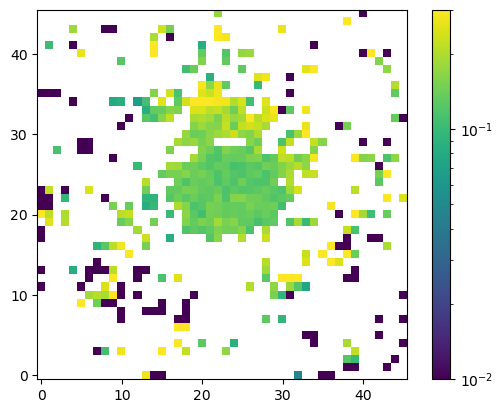

In [3]:
plt.imshow(ratio,norm=mpl.colors.LogNorm(vmax=0.3,vmin=0.01),origin='lower')
plt.colorbar()
plt.show()

In [12]:
contfreq=225*u.GHz
ds1=87*u.mJy

equiv=u.brightness_temperature(contfreq)
bmaj=0.35*u.arcsec
beamarea_sr=(np.pi*(bmaj/2)**2).to('sr')
mjysr=ds1/beamarea_sr
conv=mjysr.to('K',equivalencies=equiv)
print(conv)

24.73469959536386 K


In [11]:
beamarea_sr

<Quantity 2.26139123e-12 sr>